Na dnešních cvičeních se podíváme na dva algoritmy z oblasti rojové inteligence - optimalizaci pomocí kolonií mravenců (Ant Colony Optimization) a pomocí hejn částic (Particle Swarm Optimization).

Oba algoritmy jsou relativně snadné na implementaci a proto je napíšeme od začátku.

## Ant Colony Optimization

ACO algoritmus se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na hledání cest v grafu. Jako příklad si pomocí ACO vyřešíme problém obchodního cestujícího, tedy problém hledání nejkratší Hamiltonovské kružnice v úplném grafu.

In [12]:
from collections import namedtuple
import math
import functools

import numpy as np

Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

# hlavni kod ACO
def ant_solver(vertices, distance, ants=10, max_iter=3000, alpha=1, beta=3, Q=100, rho=0.8):
    P = initialize_pheromone(len(vertices))
    best_sol = None
    best_fit = float('inf')
    for it in range(max_iter):
        sols = list(generate_solutions(vertices, P, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), sols))
        P = update_pheromone(P, sols, fits, Q=Q, rho=rho)
        
        for s, f in zip(sols, fits):
            if f < best_fit:
                best_fit = f
                best_sol = s
        
        print(f'{it:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_sol, P

# vypocet vzdalenosti
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

# vypocet fitness
def fitness(vertices, dist, sol):
    sd = 0
    for x, y in zip(sol, sol[1:]):
        sd += dist(vertices[x], vertices[y])
    sd += dist(vertices[sol[-1]], vertices[sol[0]])
    return sd

# pocatecni inicializace feromonu
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

# vytvoreni reseni
def generate_solutions(vertices, P, dist, N, alpha=1, beta=3):
    
    # pravdepodobnost vyberu hrany (bez skalovani)
    def compute_prob(v1, v2):
        nu = 1/dist(vertices[v1], vertices[v2])
        tau = P[v1, v2]
        ret = pow(tau, alpha) * pow(nu,beta)
        return ret if ret > 0.000001 else 0.000001

    V = P.shape[0]
    for i in range(N):
        available = list(range(V))
        sol = [np.random.randint(0, V)]
        available.remove(sol[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(sol[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            sol.append(selected)
            available.remove(selected)
        yield sol

def update_pheromone(P, sols, fits, Q=100, rho=0.6):
    ph_update = np.zeros(shape=P.shape)
    for s, f in zip(sols, fits):
        for x, y in zip(s, s[1:]):
            ph_update[x][y] += Q/f
        ph_update[s[-1]][s[0]] += Q/f
    
    return (1-rho)*P + ph_update        

In [13]:
import csv

# otestujeme algoritmus na evropskych hlavnich mestech
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

import pprint
        
pprint.pprint(vertices)

s, P = ant_solver(vertices, distance)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

 194, 256.1758, 288.4486, 317.0153
 195, 273.5683, 296.9916, 334.6661
 196, 260.9873, 285.5905, 310.0571
 197, 265.0571, 291.8772, 369.2843
 198, 267.8552, 303.7922, 353.2326
 199, 265.5156, 300.0980, 353.7640
 200, 264.6117, 296.6875, 321.2332
 201, 248.5529, 285.4459, 326.5447
 202, 253.1602, 293.6865, 318.8817
 203, 270.1316, 297.2729, 367.6427
 204, 268.9571, 293.2430, 318.0848
 205, 265.3406, 296.9449, 317.1561
 206, 252.0884, 284.3299, 303.9582
 207, 260.4877, 294.4119, 320.1615
 208, 267.2865, 286.8122, 307.5618
 209, 253.7525, 284.1977, 319.4835
 210, 270.7613, 299.5619, 323.9806
 211, 268.1131, 285.5725, 306.3818
 212, 267.3883, 289.8420, 334.4984
 213, 268.0496, 302.9770, 367.7925
 214, 268.9302, 297.8987, 352.6854
 215, 268.9425, 299.7934, 377.5540
 216, 272.3547, 301.7696, 339.3205
 217, 272.3547, 300.9960, 319.8909
 218, 258.9819, 294.1293, 312.8456
 219, 264.3256, 293.0942, 320.0858
 220, 258.3950, 283.4398, 325.1759
 221, 257.3633, 296.4656, 356.3106
 222, 266.2315, 282.

 440, 254.6297, 277.7474, 299.2841
 441, 257.4264, 283.9516, 345.2184
 442, 263.1005, 289.6231, 330.9869
 443, 276.1148, 298.3257, 352.1788
 444, 262.6168, 283.3575, 332.9217
 445, 258.6855, 295.6032, 338.1966
 446, 257.4264, 276.9171, 297.2948
 447, 263.9001, 294.5185, 347.1620
 448, 261.6434, 283.7105, 316.5616
 449, 251.4430, 274.1419, 299.5162
 450, 261.6434, 296.3686, 360.9547
 451, 258.6855, 285.3349, 318.8949
 452, 262.0310, 288.7959, 315.0505
 453, 258.6855, 291.2469, 317.4236
 454, 275.7961, 297.0429, 346.1461
 455, 267.0051, 293.0187, 321.8656
 456, 266.4879, 292.6631, 325.5788
 457, 260.4100, 291.9982, 345.5133
 458, 271.1104, 291.5251, 331.8013
 459, 255.6994, 287.0359, 314.7692
 460, 266.8204, 283.0733, 308.2043
 461, 260.2055, 292.0120, 337.1559
 462, 262.4495, 287.8667, 315.6590
 463, 264.9521, 295.2239, 329.3790
 464, 262.3180, 291.5111, 317.6626
 465, 257.8951, 287.3072, 325.8129
 466, 256.1836, 270.5289, 284.4361
 467, 256.1836, 294.3708, 339.9989
 468, 255.4303, 273.

 712, 268.7146, 289.3658, 330.5075
 713, 247.4223, 276.2493, 299.5494
 714, 255.6518, 279.1502, 296.8313
 715, 256.1352, 280.9174, 306.0542
 716, 257.8529, 283.3239, 306.7649
 717, 244.3939, 278.4666, 299.8930
 718, 256.1352, 286.8656, 322.7022
 719, 252.9741, 283.0620, 304.2571
 720, 243.0736, 282.1259, 310.1711
 721, 259.4701, 287.5185, 336.5084
 722, 245.6323, 276.1912, 309.8371
 723, 245.8039, 282.2387, 343.4594
 724, 259.1247, 286.9546, 317.6716
 725, 255.9650, 295.4825, 363.2243
 726, 265.5594, 288.0692, 308.7942
 727, 250.1891, 287.1850, 331.4438
 728, 258.9863, 283.0198, 311.7851
 729, 250.1669, 279.8310, 303.4237
 730, 265.0461, 287.1764, 318.9155
 731, 264.5416, 288.7489, 343.8984
 732, 243.0736, 280.9424, 315.8253
 733, 279.1021, 296.1011, 347.5691
 734, 260.3977, 284.7032, 311.3136
 735, 260.7373, 294.2912, 322.3432
 736, 253.6018, 281.3158, 317.9153
 737, 254.0717, 273.4065, 299.2100
 738, 260.1871, 272.4412, 291.0111
 739, 253.6018, 274.2767, 294.4099
 740, 259.1055, 273.

 955, 278.5043, 303.5453, 328.2125
 956, 271.1290, 301.2407, 312.8473
 957, 287.7206, 307.5159, 332.8171
 958, 263.3855, 306.9749, 351.1083
 959, 273.4826, 307.5388, 333.5034
 960, 286.5329, 302.6553, 313.3032
 961, 294.8867, 315.0181, 364.8489
 962, 290.0876, 314.4191, 359.1636
 963, 287.1560, 321.9473, 379.0909
 964, 292.5589, 308.4283, 338.6256
 965, 287.6006, 308.8807, 367.7497
 966, 287.6006, 304.2506, 335.4733
 967, 287.7206, 315.7733, 357.4831
 968, 287.6006, 311.0581, 346.4390
 969, 287.7206, 305.4671, 339.3561
 970, 288.4772, 310.8679, 335.3719
 971, 287.6006, 306.9207, 338.5352
 972, 270.0589, 311.5877, 351.6164
 973, 278.0008, 303.5220, 335.3495
 974, 275.1468, 314.8998, 379.1910
 975, 287.7206, 312.7910, 386.4955
 976, 283.0518, 304.1381, 327.7062
 977, 268.0273, 303.9139, 334.4563
 978, 289.7571, 307.2899, 337.2129
 979, 287.7206, 314.5128, 350.8354
 980, 275.1735, 308.0650, 345.7139
 981, 290.5622, 302.6123, 314.2308
 982, 281.4071, 305.5335, 328.8780
 983, 282.3225, 299.

1206, 243.8483, 281.2844, 294.1284
1207, 252.9065, 286.6984, 332.3789
1208, 254.2814, 295.6528, 336.9998
1209, 248.8166, 282.3086, 329.4195
1210, 260.2882, 286.2318, 333.4208
1211, 248.7790, 284.1985, 339.0610
1212, 243.4281, 288.5927, 345.3385
1213, 265.0955, 294.0516, 384.8030
1214, 249.8083, 283.8424, 342.4824
1215, 265.2268, 295.6864, 352.0242
1216, 251.7998, 279.7578, 299.0829
1217, 242.3982, 268.3523, 305.6415
1218, 242.1630, 267.4681, 295.9697
1219, 240.8887, 277.2043, 379.6288
1220, 243.5741, 268.6650, 303.1814
1221, 238.0671, 269.0489, 305.9620
1222, 238.0671, 275.9606, 333.0562
1223, 238.0671, 277.3850, 317.5187
1224, 241.3223, 275.0721, 295.7026
1225, 234.9796, 289.3238, 338.7132
1226, 234.9796, 285.0268, 310.0236
1227, 263.9171, 278.5105, 288.6704
1228, 262.4038, 286.0069, 321.9749
1229, 273.7335, 284.0975, 312.2253
1230, 261.0062, 276.4366, 292.9389
1231, 248.4378, 285.1171, 315.0877
1232, 240.7652, 291.7273, 346.4232
1233, 258.6775, 282.9505, 322.4805
1234, 250.9890, 276.

1447, 257.0803, 305.2608, 359.3657
1448, 257.0803, 295.8170, 341.8027
1449, 248.4378, 286.6180, 320.4161
1450, 252.9543, 293.9197, 349.9239
1451, 252.9543, 299.3478, 358.8931
1452, 254.6175, 294.5452, 341.2973
1453, 268.6169, 295.6998, 331.4618
1454, 269.9209, 300.3887, 341.2973
1455, 268.6169, 303.8859, 354.9274
1456, 283.4971, 299.4073, 354.9274
1457, 280.2254, 298.3941, 323.2036
1458, 251.8505, 291.5047, 333.2572
1459, 259.4940, 297.7592, 344.6720
1460, 272.5820, 298.2498, 341.0891
1461, 258.5561, 289.9821, 370.1467
1462, 258.5561, 288.7494, 323.3161
1463, 264.3135, 285.8274, 303.3702
1464, 262.6822, 287.9826, 313.7532
1465, 265.7535, 283.3605, 313.3915
1466, 251.5080, 288.3412, 338.3477
1467, 265.7535, 296.7784, 322.6952
1468, 258.7993, 280.8551, 313.2962
1469, 279.2254, 305.5459, 344.3656
1470, 251.5080, 287.9337, 356.4470
1471, 251.5080, 295.8025, 358.9041
1472, 232.9301, 279.8480, 314.6098
1473, 248.4378, 297.1719, 341.7561
1474, 258.7993, 296.7413, 341.5769
1475, 259.9237, 300.

1713, 257.0058, 285.5782, 320.1856
1714, 258.7993, 289.7353, 325.7719
1715, 264.9452, 292.0599, 320.0940
1716, 244.2610, 290.6922, 328.4599
1717, 258.7993, 283.9558, 338.5548
1718, 254.5253, 284.9012, 317.2516
1719, 258.7993, 283.5545, 334.2545
1720, 258.4017, 277.5295, 327.0270
1721, 262.9716, 288.4972, 318.7536
1722, 267.2126, 299.1912, 355.3298
1723, 248.4378, 281.2073, 300.9974
1724, 253.4698, 281.0186, 318.4978
1725, 259.1995, 283.4221, 316.4757
1726, 267.0575, 300.3619, 347.0686
1727, 259.3946, 280.4631, 328.4503
1728, 254.7982, 283.9505, 333.0122
1729, 258.0702, 281.8480, 343.6441
1730, 254.7982, 279.4605, 351.5635
1731, 233.9234, 269.4694, 296.0460
1732, 253.7723, 282.7459, 323.3628
1733, 263.2165, 283.3982, 321.2742
1734, 258.5561, 279.7351, 297.9730
1735, 258.7993, 287.6174, 318.6307
1736, 259.1616, 276.2974, 298.6854
1737, 248.4378, 278.5317, 297.6160
1738, 257.3900, 282.1612, 315.0531
1739, 261.9269, 287.1690, 318.1546
1740, 255.9020, 273.8285, 300.5957
1741, 255.2450, 277.

1994, 261.1999, 285.0266, 305.8398
1995, 263.4331, 286.6923, 302.9706
1996, 263.9888, 294.2208, 326.4187
1997, 268.7087, 299.0924, 342.2633
1998, 263.9888, 285.8771, 308.9953
1999, 263.1161, 276.9499, 292.2687
2000, 263.1161, 286.4975, 303.5125
2001, 263.1161, 291.8363, 333.2742
2002, 270.9533, 295.5624, 314.9377
2003, 267.1170, 282.1439, 304.8000
2004, 268.7577, 293.6114, 340.2608
2005, 259.4908, 286.4932, 318.3269
2006, 263.1161, 285.8056, 319.4230
2007, 265.2657, 295.8335, 319.2702
2008, 269.2619, 295.1451, 320.4781
2009, 239.1110, 288.7151, 323.0168
2010, 240.1752, 270.5294, 311.0599
2011, 258.4733, 282.0205, 305.6254
2012, 247.3148, 280.7780, 334.4565
2013, 250.1403, 297.0635, 341.7309
2014, 247.3148, 277.1683, 328.9940
2015, 250.0699, 270.7985, 294.3484
2016, 249.2706, 281.4209, 326.0718
2017, 254.8998, 284.5839, 345.5245
2018, 260.3563, 292.8233, 349.7692
2019, 260.9480, 293.6206, 340.6714
2020, 263.6575, 292.1725, 311.6443
2021, 261.8494, 279.4385, 304.9507
2022, 264.3010, 284.

2278, 274.5816, 297.2016, 330.8879
2279, 274.0700, 290.1435, 318.9527
2280, 258.0702, 294.9521, 329.1004
2281, 270.2470, 288.3111, 307.5921
2282, 268.8138, 285.8515, 315.3789
2283, 264.9190, 290.6651, 337.8010
2284, 259.4087, 293.7479, 361.5992
2285, 248.6735, 284.3793, 305.0332
2286, 254.1766, 300.7540, 341.4193
2287, 249.2084, 292.0122, 364.0176
2288, 251.1225, 290.2904, 332.2928
2289, 259.7819, 283.0939, 311.8995
2290, 261.6561, 281.4348, 308.6520
2291, 261.4116, 286.3739, 314.0282
2292, 261.4116, 291.8712, 324.1369
2293, 250.2743, 287.3497, 321.9125
2294, 273.8496, 290.1789, 348.4922
2295, 263.1161, 286.8659, 314.7111
2296, 241.3223, 277.4543, 321.9129
2297, 250.7590, 283.9227, 329.3087
2298, 253.3888, 285.8700, 314.7065
2299, 268.2685, 293.3837, 314.7491
2300, 273.3732, 308.3983, 331.5519
2301, 271.3429, 300.3690, 325.8669
2302, 273.5179, 305.7230, 350.7479
2303, 256.4181, 289.6494, 333.2317
2304, 254.0620, 289.6405, 335.7980
2305, 261.1792, 284.4934, 318.3829
2306, 254.1766, 285.

2517, 284.6563, 297.0185, 307.9607
2518, 277.3146, 294.3382, 308.2077
2519, 271.1266, 293.0012, 304.9103
2520, 285.7163, 307.5682, 353.0155
2521, 270.2565, 301.9271, 333.9466
2522, 289.1113, 297.6705, 316.6176
2523, 270.2565, 301.1041, 333.9523
2524, 277.1871, 304.3038, 390.4730
2525, 271.9599, 295.0840, 312.1338
2526, 262.6069, 306.4571, 410.6822
2527, 273.1350, 307.1634, 354.4751
2528, 290.2271, 298.9252, 309.8792
2529, 290.2271, 308.9522, 365.4336
2530, 281.7960, 300.5059, 334.2605
2531, 285.7204, 301.7650, 331.8484
2532, 273.1350, 296.2202, 309.5098
2533, 273.1350, 311.7973, 333.0198
2534, 294.1099, 327.4926, 392.2726
2535, 263.2817, 304.7825, 367.7733
2536, 283.1668, 300.4558, 345.1133
2537, 280.6308, 307.2284, 365.7801
2538, 270.9889, 304.6922, 324.9627
2539, 264.7780, 315.7529, 360.9817
2540, 264.7780, 298.6446, 326.8127
2541, 264.7780, 300.4968, 363.7052
2542, 264.7780, 308.5692, 353.2912
2543, 268.5273, 306.7519, 358.4266
2544, 258.8838, 298.1820, 330.1623
2545, 264.7780, 293.

2767, 248.7132, 287.8538, 376.4033
2768, 261.1940, 290.4246, 323.8294
2769, 265.2768, 300.5825, 357.1885
2770, 253.5084, 286.3983, 355.7611
2771, 262.3340, 286.2512, 307.8723
2772, 247.2529, 276.4729, 319.2267
2773, 253.2818, 283.3624, 371.6828
2774, 248.1604, 277.0520, 309.7654
2775, 240.9041, 275.8966, 296.7145
2776, 247.2529, 274.5988, 313.7488
2777, 244.0254, 282.2057, 313.9011
2778, 253.1712, 278.4500, 311.6228
2779, 248.7132, 267.6736, 288.5897
2780, 245.3866, 275.1494, 288.6536
2781, 253.7339, 286.9904, 327.7775
2782, 256.0085, 283.7286, 325.0617
2783, 249.6744, 282.2603, 360.7343
2784, 250.3250, 283.8730, 321.0181
2785, 247.4422, 268.7327, 290.3796
2786, 248.2853, 282.2198, 329.4478
2787, 241.9055, 274.7383, 329.8498
2788, 242.2992, 271.4214, 314.8887
2789, 242.9391, 268.5149, 304.2745
2790, 244.1789, 275.7424, 306.2237
2791, 253.5437, 269.6550, 302.6782
2792, 240.4374, 273.1120, 310.9879
2793, 239.4581, 262.0882, 312.7525
2794, 248.8662, 266.5560, 291.6833
2795, 244.2363, 268.

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Odkomentováním zakomentované řádky se můžete vyzkoušet, jak různé nastavení `alpha` a `beta` ovlivňuje nalezená řešení.

Fitness:  258.4992212850321
[Vertex(name='Belgrade', x=20.5, y=44.81666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Bratislava', x=17.11666667, y=48.15),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='Monaco', x=7.416666667, y=43.73333333),
 Vertex(name='Vaduz', x=9.516666667, y=47.13333333),
 Vertex(name='Bern', x=7.433333333, y=46.95),
 Vertex(name='Luxemburg', x=6.116666667, y=49.61666667),
 Vertex(name='Amsterdam', x=4.883333333, y=52.36666667),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Madrid', x=-3.7, y=40.41666667),
 Vertex(name='Lisbon', x=-9.133333333, y=38.71666667),
 Verte

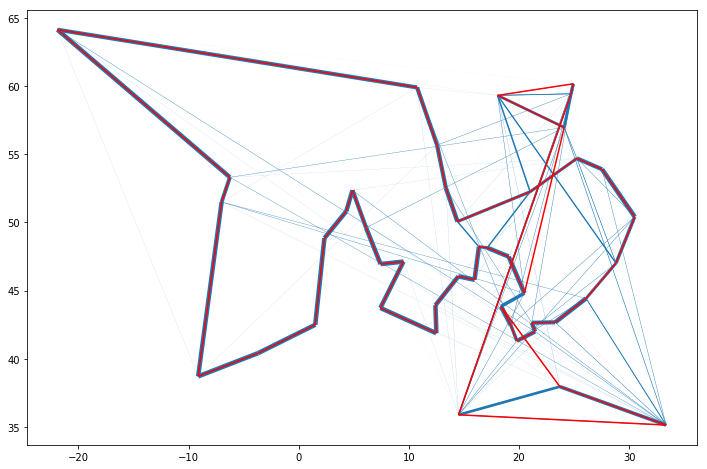

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# vykreslime modre feromon, tloustka cary ukazuje mnozstvi feromonu na hrane
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(P[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

best_sol = sol # ulozime si nejplepsi reseni (kvuli experimentum nize)

sol = best_sol

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# sol = list(generate_solutions(vertices, P, distance, N=1, alpha=3, beta=1))[0]

# vypiseme fitness reseni
print('Fitness: ', fitness(vertices, distance, sol))

# vypiseme primo poradi mest
sol_verts = [vertices[i] for i in sol]
pprint.pprint(sol_verts)

# vykreslime cervene reseni
sol_lines = []
for i, j in zip(sol, sol[1:]):
    sol_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])

sol_lines.append([(vertices[sol[-1]].x, vertices[sol[-1]].y), (vertices[sol[0]].x, vertices[sol[0]].y)])

sols_lc = mc.LineCollection(sol_lines, colors='red')
ax.add_collection(sols_lc)

## Optimalizace hejnem částic

Algoritmus optimalizace hejnem částic je velmi jednoduchý na implementaci. V zásadě stačí přímo opsat rovnice.

In [45]:
class Particle:
    def __init__(self, x, v):
        self.x = x
        self.v = v
        self.p_best = x
            
    def __repr__(self):
        return str(self.x) + ', ' + str(self.v) + ', ' + str(self.p_best)

# velmi jednoducha fitness pro otestovani
def fitness(x):
    return np.linalg.norm(x)

# hlavni kod PSO
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(N=swarm_size, D=problem_dim)
    g_best = compute_gbest(swarm, fitness)
    for it in range(max_iters):
        swarm = update_swarm(swarm, fitness, g_best)
        g_best = compute_gbest(swarm, fitness)
        print(f'{it:4}: {fitness(g_best):.4f}')
    
    return g_best
    
# nahodna inicializace swarmu - pozice i rychlosti nahodne (rychlosti jsou typicky mensi)
def init_swarm(N, D):
    swarm = []
    for _ in range(N):
        swarm.append(Particle(x = np.random.uniform(size=(1,D)), v = 0.2*np.random.uniform(size=(1,D)) - 0.1))
    return swarm

# update globalniho nejlepsiho reseni
def compute_gbest(swarm, fit):
    return min(swarm, key=lambda x: fit(x.p_best)).p_best

# aktualizace swarmu - hlavni cast algoritmu
def update_swarm(swarm, fit, g_best, phi_p=1, phi_b=0.5, omega=0.95):
    for p in swarm:
        p.v = omega*p.v + phi_p*(p.p_best - p.x) + phi_b*(g_best - p.x)
        p.x = p.x + p.v
        
        if fit(p.x) < fit(p.p_best):
            p.p_best=p.x

    return swarm

# otestujeme PSO
pso(fitness, swarm_size=100, problem_dim=5, max_iters=100)

   0: 0.4209
   1: 0.2727
   2: 0.2681
   3: 0.1762
   4: 0.1712
   5: 0.0560
   6: 0.0560
   7: 0.0384
   8: 0.0311
   9: 0.0311
  10: 0.0191
  11: 0.0191
  12: 0.0191
  13: 0.0191
  14: 0.0177
  15: 0.0167
  16: 0.0167
  17: 0.0166
  18: 0.0166
  19: 0.0166
  20: 0.0166
  21: 0.0152
  22: 0.0105
  23: 0.0066
  24: 0.0066
  25: 0.0058
  26: 0.0058
  27: 0.0058
  28: 0.0055
  29: 0.0045
  30: 0.0032
  31: 0.0026
  32: 0.0024
  33: 0.0024
  34: 0.0024
  35: 0.0024
  36: 0.0024
  37: 0.0024
  38: 0.0020
  39: 0.0020
  40: 0.0019
  41: 0.0018
  42: 0.0017
  43: 0.0016
  44: 0.0014
  45: 0.0014
  46: 0.0010
  47: 0.0010
  48: 0.0010
  49: 0.0010
  50: 0.0008
  51: 0.0008
  52: 0.0008
  53: 0.0008
  54: 0.0007
  55: 0.0007
  56: 0.0007
  57: 0.0007
  58: 0.0007
  59: 0.0007
  60: 0.0007
  61: 0.0005
  62: 0.0005
  63: 0.0005
  64: 0.0005
  65: 0.0005
  66: 0.0005
  67: 0.0005
  68: 0.0004
  69: 0.0004
  70: 0.0004
  71: 0.0004
  72: 0.0004
  73: 0.0004
  74: 0.0004
  75: 0.0004
  76: 0.0004

array([[-5.11214051e-06, -8.79869768e-05,  3.16774036e-04,
         1.13371344e-05,  2.28405777e-04]])